Width: 7551
Height: 7711
Number of bands: 1
Coordinate Reference System (CRS): EPSG:32615
Transform: | 30.00, 0.00, 623085.00|
| 0.00,-30.00, 1714515.00|
| 0.00, 0.00, 1.00|
Metadata: {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 7551, 'height': 7711, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(30.0, 0.0, 623085.0,
       0.0, -30.0, 1714515.0)}


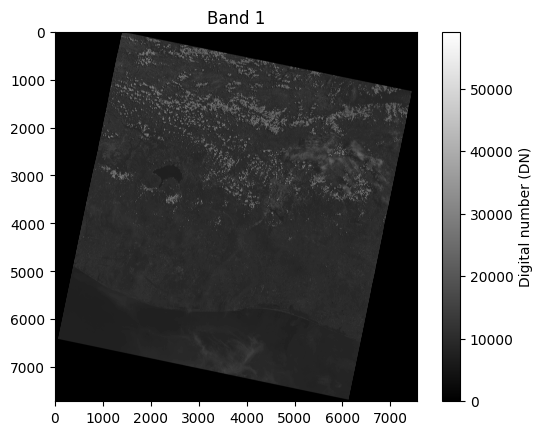

In [4]:
import rasterio
import matplotlib.pyplot as plt

# Path to your raster file
file_path = 'LC08_L2SP_020050_20180625_20200831_02_T1_SR_B7.TIF'  # Change this to the path of your raster file

# Open the raster file
with rasterio.open(file_path) as src:
    # Print basic information about the raster file
    print(f"Width: {src.width}")
    print(f"Height: {src.height}")
    print(f"Number of bands: {src.count}")
    print(f"Coordinate Reference System (CRS): {src.crs}")
    print(f"Transform: {src.transform}")
    
    # Read the first band
    band1 = src.read(1)
    
    # Metadata for the entire file
    print(f"Metadata: {src.meta}")

# Visualize the first band using Matplotlib
plt.imshow(band1, cmap='gray')
plt.title('Band 1')
plt.colorbar(label='Digital number (DN)')
plt.show()


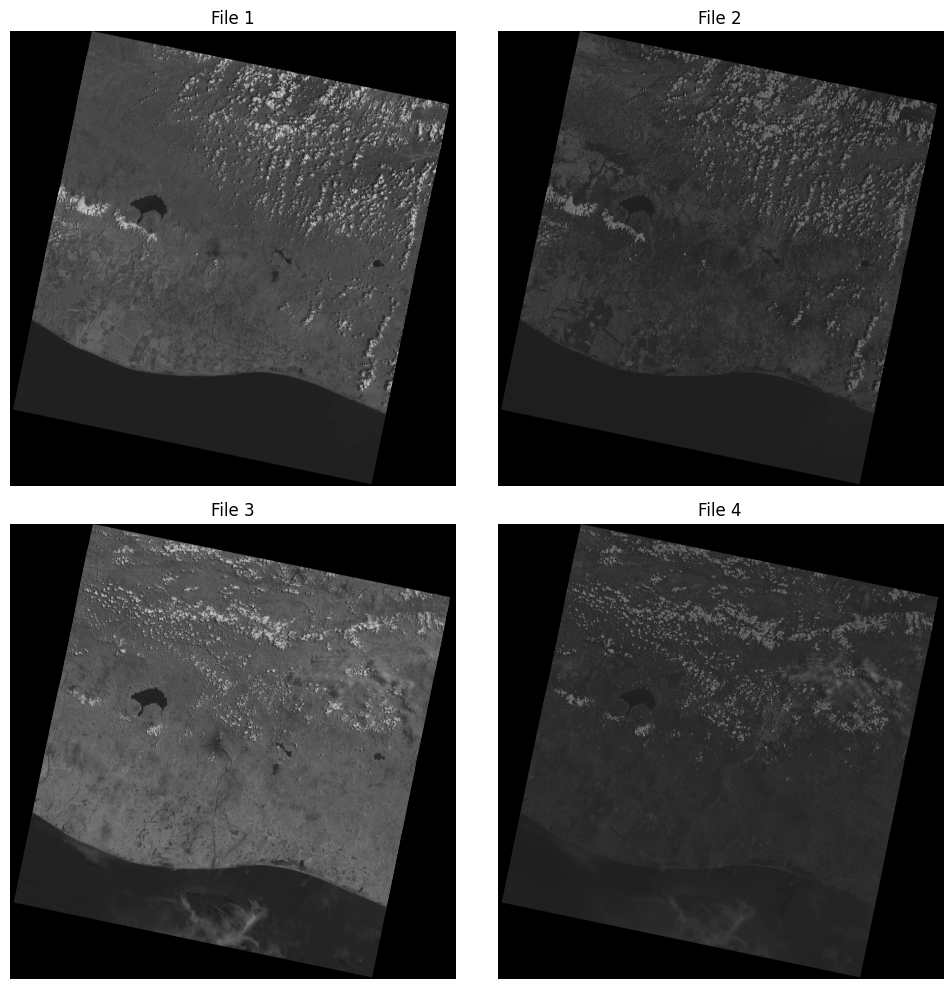

In [5]:
import rasterio
import matplotlib.pyplot as plt

# Define file paths
file_paths = [
    'LC08_L2SP_020050_20180321_20200901_02_T1_SR_B5.TIF',
    'LC08_L2SP_020050_20180321_20200901_02_T1_SR_B7.TIF',
    'LC08_L2SP_020050_20180625_20200831_02_T1_SR_B5.TIF',
    'LC08_L2SP_020050_20180625_20200831_02_T1_SR_B7.TIF'
]

# Common dimensions
common_width = 7541
common_height = 7711

# Initialize a plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, file_path in enumerate(file_paths):
    with rasterio.open(file_path) as src:
        # Determine the width to read (min between common width and image width)
        width_to_read = min(common_width, src.width)
        
        # Read the image data for the common area
        # Note: Assuming we trim from the right if the image is wider than common_width
        image_data = src.read(1, window=rasterio.windows.Window(0, 0, width_to_read, common_height))
        
        # Plot
        ax = axs[i // 2, i % 2]
        ax.imshow(image_data, cmap='gray')
        ax.set_title(f"File {i+1}")
        ax.axis('off')

plt.tight_layout()
plt.show()


In [21]:
import rasterio
from rasterio.windows import from_bounds
from shapely.geometry import box

# Function to calculate geographic extent of a raster file
def get_geographic_extent(file_path):
    with rasterio.open(file_path) as src:
        # Calculate bounds: left, bottom, right, top
        bounds = src.bounds
        return box(*bounds)  # Create a box (polygon) from these bounds

# Paths to your files
file_paths = [
    'LC08_L2SP_020050_20180321_20200901_02_T1_SR_B5.TIF',
    'LC08_L2SP_020050_20180321_20200901_02_T1_SR_B7.TIF',
    'LC08_L2SP_020050_20180625_20200831_02_T1_SR_B5.TIF',
    'LC08_L2SP_020050_20180625_20200831_02_T1_SR_B7.TIF'
]

# Calculate geographic extents
extents = [get_geographic_extent(path) for path in file_paths]

# Find common area
common_area = extents[0]
for extent in extents[1:]:
    common_area = common_area.intersection(extent)

if common_area.is_empty:
    raise ValueError("No common geographic area found among the files.")

# The common_area is now the intersection of all extents.
# You'd then convert this common geographic area back to pixel coordinates for each image
# and extract the data for that region.


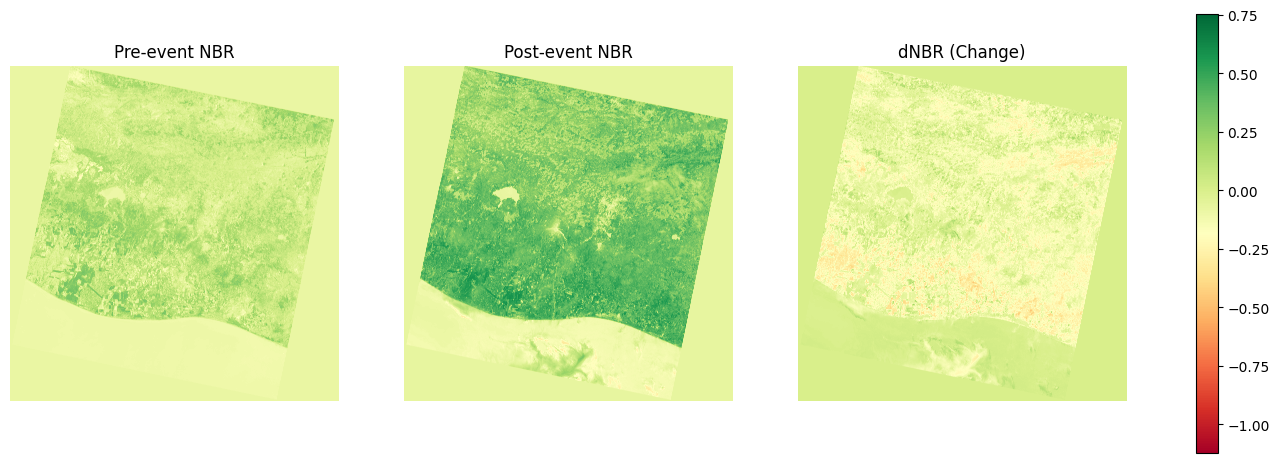

In [22]:
import rasterio
from rasterio.warp import reproject, calculate_default_transform
from rasterio.enums import Resampling
import numpy as np
import matplotlib.pyplot as plt

# Define your image paths
pre_event_nir_path = 'LC08_L2SP_020050_20180321_20200901_02_T1_SR_B5.TIF'
pre_event_swir_path = 'LC08_L2SP_020050_20180321_20200901_02_T1_SR_B7.TIF'
post_event_nir_path = 'LC08_L2SP_020050_20180625_20200831_02_T1_SR_B5.TIF'
post_event_swir_path = 'LC08_L2SP_020050_20180625_20200831_02_T1_SR_B7.TIF'

def align_and_reproject(src_path, ref_path, dst_path):
    with rasterio.open(src_path) as src, rasterio.open(ref_path) as ref:
        # Calculate the transformation needed to align the source to the reference
        transform, width, height = calculate_default_transform(
            src.crs, ref.crs, ref.width, ref.height, *ref.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': ref.crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Reproject and align the source image to the reference image
        with rasterio.open(dst_path, 'w', **kwargs) as dst:
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=ref.crs,
                resampling=Resampling.nearest)

# Align post-event images to the pre-event images
align_and_reproject(post_event_nir_path, pre_event_nir_path, 'aligned_post_event_NIR.TIF')
align_and_reproject(post_event_swir_path, pre_event_swir_path, 'aligned_post_event_SWIR.TIF')

def read_band(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1).astype('float32')

def calculate_nbr(nir_band, swir_band):
    nbr = (nir_band - swir_band) / (nir_band + swir_band + 1e-10)  # Avoid division by zero
    return nbr

# Read bands
nir_pre = read_band(pre_event_nir_path)
swir_pre = read_band(pre_event_swir_path)
nir_post = read_band('aligned_post_event_NIR.TIF')
swir_post = read_band('aligned_post_event_SWIR.TIF')

# Calculate NBR for pre and post events
nbr_pre = calculate_nbr(nir_pre, swir_pre)
nbr_post = calculate_nbr(nir_post, swir_post)

# Calculate dNBR
dnbr = nbr_pre - nbr_post

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
cmap = 'RdYlGn'

axes[0].imshow(nbr_pre, cmap=cmap)
axes[0].set_title('Pre-event NBR')
axes[0].axis('off')

axes[1].imshow(nbr_post, cmap=cmap)
axes[1].set_title('Post-event NBR')
axes[1].axis('off')

im = axes[2].imshow(dnbr, cmap=cmap)
axes[2].set_title('dNBR (Change)')
axes[2].axis('off')

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
plt.show()


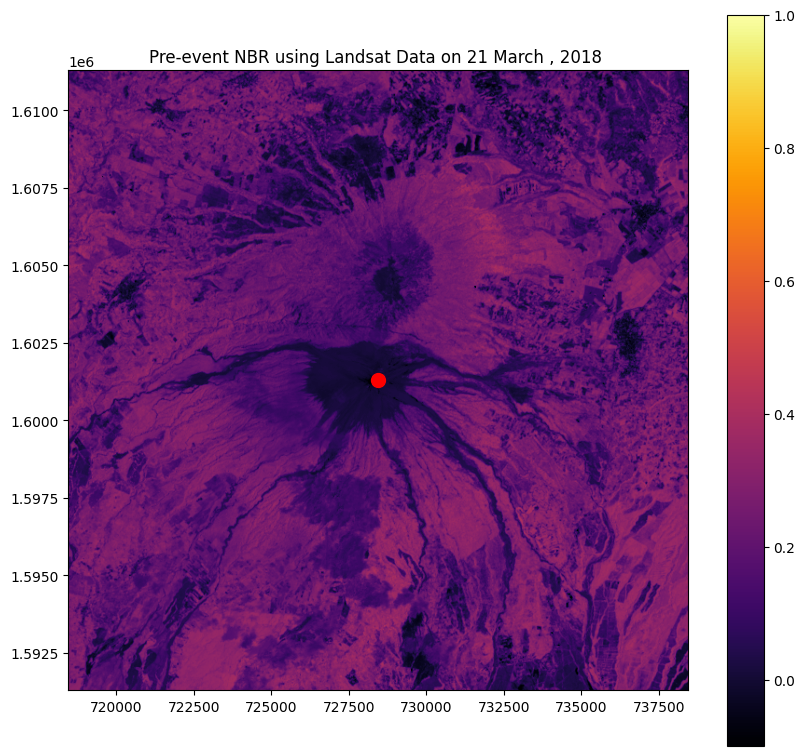

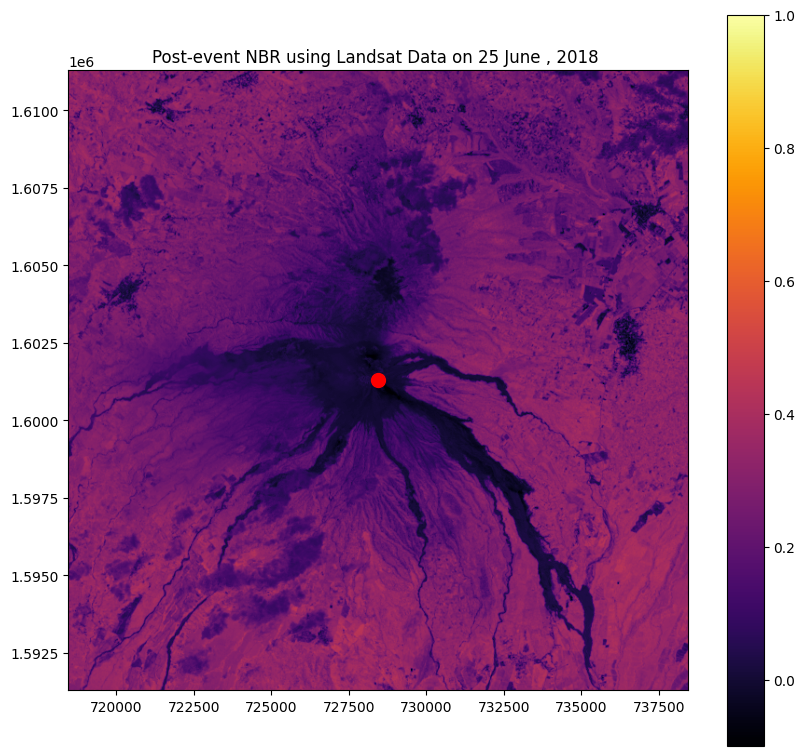

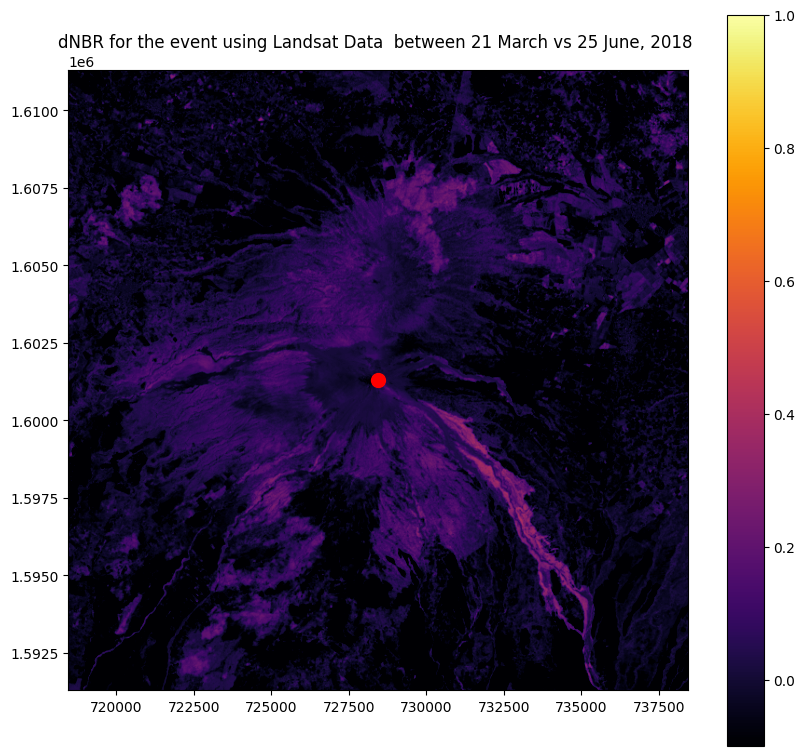

In [24]:
# Coordinates of the point of interest
easting, northing = 728443.94, 1601283.24  # Example coordinates
distance = 10000  # 10 kilometers

# Function to plot each scenario
def plot_scenario(data, title, easting, northing, distance):
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(data, cmap=plt.cm.inferno, extent=[623085, 623085 + 7551*30, 1714515 - 7711*30, 1714515], vmin=-0.1, vmax=1.0)
    ax.scatter(easting, northing, s=100, c="red", label='Point of Interest')
    ax.set_xlim(easting - distance, easting + distance)
    ax.set_ylim(northing - distance, northing + distance)
    ax.set_title(title)
    plt.colorbar(im, ax=ax, shrink=0.95)
    plt.show()

# Plotting
plot_scenario(nbr_pre, 'Pre-event NBR using Landsat Data on 21 March , 2018 ', easting, northing, distance)
plot_scenario(nbr_post, 'Post-event NBR using Landsat Data on 25 June , 2018 ', easting, northing, distance)
plot_scenario(dnbr, 'dNBR for the event using Landsat Data  between 21 March vs 25 June, 2018 ', easting, northing, distance)


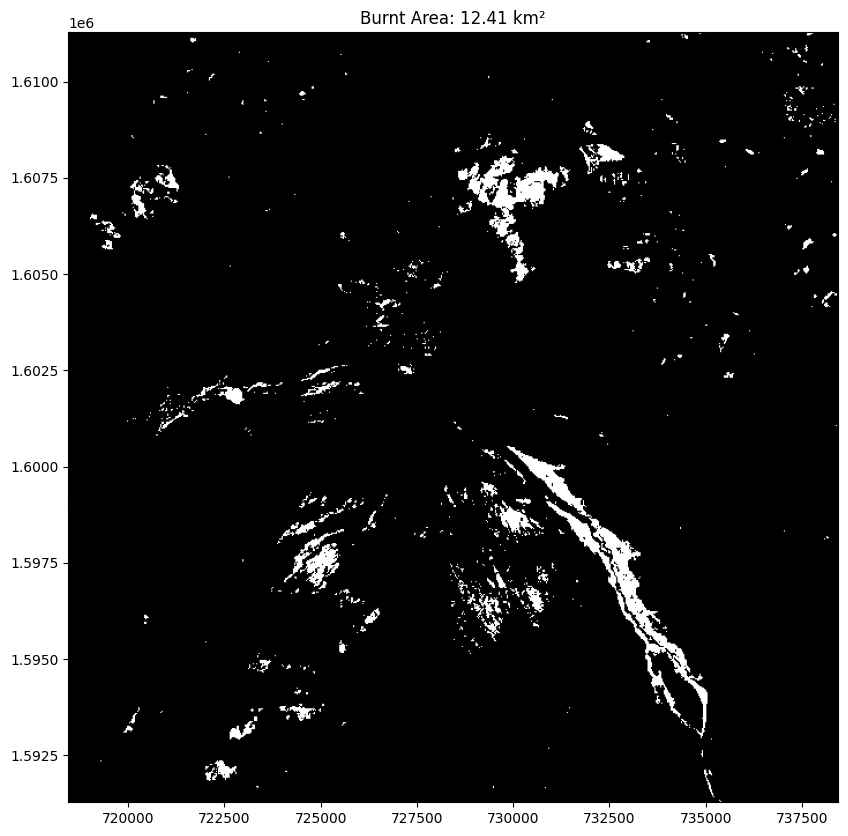

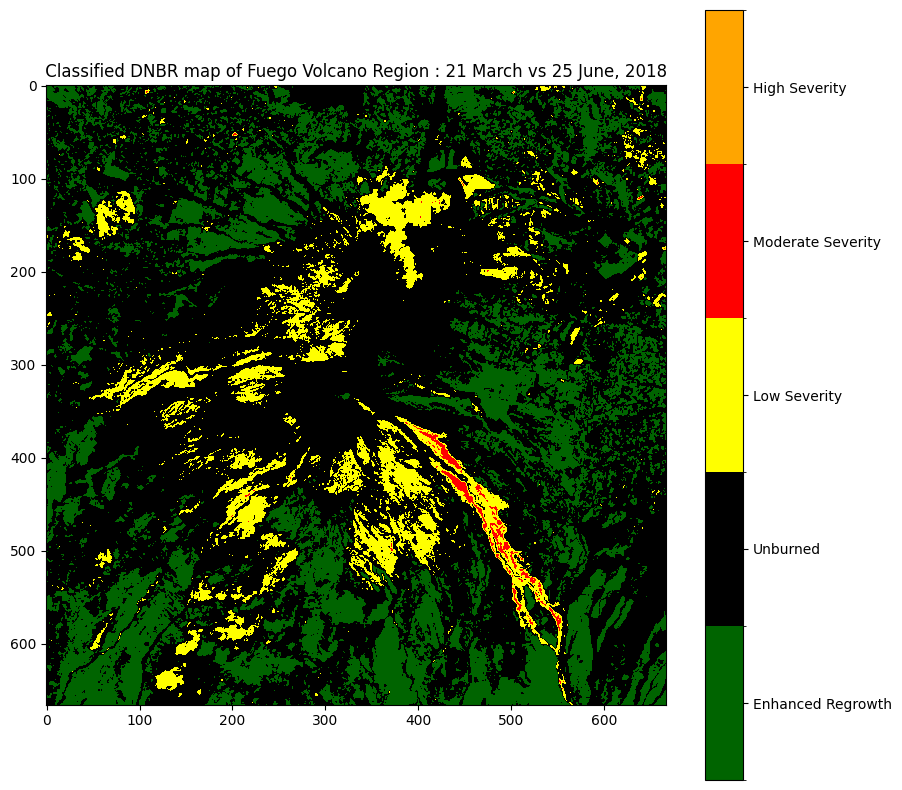

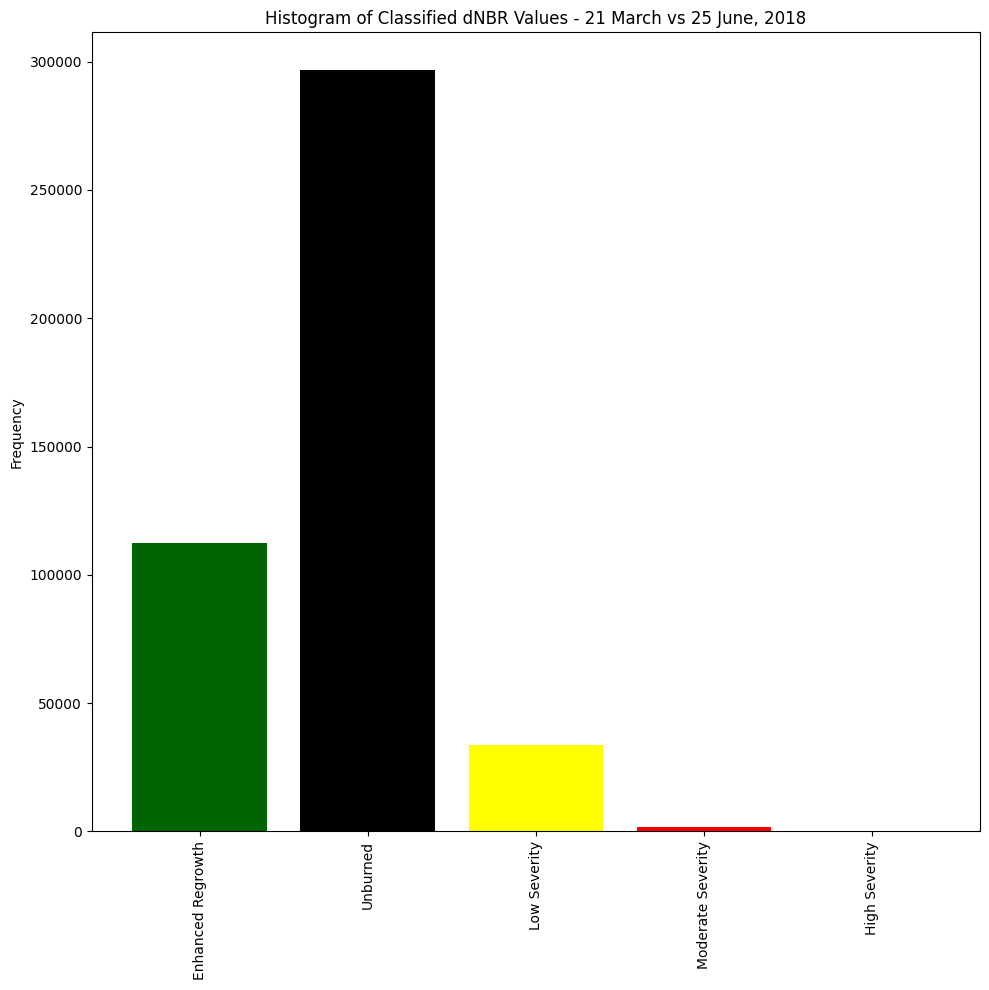

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming nbr_pre, nbr_post, and dnbr are NumPy arrays covering your area of interest.

# Coordinates and analysis parameters
easting, northing = 728443.94, 1601283.24  # Example coordinates for analysis
distance_burnt = 10000  # meters

# Assuming you have the transformation from geographic coordinates to array indices.
# For simplicity, this example uses placeholders for the transformation.
# You'll need to replace these with your actual transformation logic.
def coords_to_indices(easting, northing, transform):
    # Placeholder for actual conversion logic
    col, row = int((easting - transform['easting_offset']) / transform['pixel_width']), \
               int((northing - transform['northing_offset']) / -transform['pixel_height'])
    return row, col

transform = {'easting_offset': 623085, 'northing_offset': 1714515, 'pixel_width': 30, 'pixel_height': 30}  # Example transform

# Calculate indices for the window
row_min, col_min = coords_to_indices(easting - distance_burnt, northing + distance_burnt, transform)
row_max, col_max = coords_to_indices(easting + distance_burnt, northing - distance_burnt, transform)

# Clip the data
dnbr_clipped = dnbr[row_min:row_max, col_min:col_max]

# Threshold for identifying burnt areas
threshold = 0.15
burnt = (dnbr_clipped > threshold).astype(int)
area_burnt_km2 = burnt.sum() * (transform['pixel_width'] * transform['pixel_height']) / 1e6

# Visualize the burnt areas
plt.figure(figsize=(10, 10))
plt.imshow(burnt, cmap='binary_r', extent=[easting - distance_burnt, easting + distance_burnt, northing - distance_burnt, northing + distance_burnt])
plt.title(f'Burnt Area: {area_burnt_km2:.2f} km²')
plt.show()



cmap = mcolors.ListedColormap(['darkgreen', 'black', 'yellow', 'red', 'orange'])

# Define burn severity categories and their corresponding indices and colors
thresholds = {
    'Enhanced Regrowth': (-np.inf, -0.1),
    'Unburned': (-0.1, 0.1),
    'Low Severity': (0.1, 0.27),
    'Moderate Severity': (0.27, 0.66),
    'High Severity': (0.66, np.inf)
}
categories = list(thresholds.keys())  # ['Enhanced Regrowth', 'Unburned', 'Low Severity', 'Moderate Severity', 'High Severity']

dnbr_classified = np.zeros_like(dnbr_clipped, dtype=np.float32)
for i, (category, (min_val, max_val)) in enumerate(thresholds.items(), 1):
    dnbr_classified[(dnbr_clipped >= min_val) & (dnbr_clipped < max_val)] = i

norm = mcolors.BoundaryNorm(np.arange(0.5, len(categories)+1), cmap.N)
plt.figure(figsize=(10, 10))
img = plt.imshow(dnbr_classified, cmap=cmap, norm=norm)
cbar = plt.colorbar(img, ticks=np.arange(1, len(categories)+1))
cbar.set_ticklabels(categories)
plt.title(" Classified DNBR map of Fuego Volcano Region : 21 March vs 25 June, 2018 ")
plt.show()

# Initialize a dictionary to count occurrences of each category
category_counts = {category: 0 for category in categories}

# Update counts based on the classified data
unique, counts = np.unique(dnbr_classified, return_counts=True)
for u, count in zip(unique, counts):
    category_counts[categories[int(u)-1]] = count

# Plotting the histogram with matching colors
plt.figure(figsize=(10, 10))
bars = plt.bar(category_counts.keys(), category_counts.values(), color=['darkgreen', 'black', 'yellow', 'red', 'orange'])
plt.xticks(rotation='vertical')
plt.title('Histogram of Classified dNBR Values - 21 March vs 25 June, 2018')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()





